# Question 2.2, SVD

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import TruncatedSVD
import os, os.path
from PIL import Image
from scipy.sparse import lil_matrix
from scipy.stats import truncnorm
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [9]:
size_tup = (256,256)
count = 0
imageNameArr = []
categoryArr = []
sizeArr = []
grayImageArr = []
cumSizeArr = []
indArr = []
animalPath = 'Data/Animal'
fungusPath = 'Data/Fungus'
geoPath = 'Data/Geological Formation'
personPath = 'Data/Person'
plantPath = 'Data/Plant, flora, plant life'
sportPath = 'Data/Sport'

# animal:0, fungus:1, geo:2, person:3, plant:4, sport:5
categoryArr = [animalPath, fungusPath, geoPath, personPath, plantPath, sportPath]
totalSize = 0

for category in categoryArr:
    fold_size = len([name for name in os.listdir(category)])
    sizeArr.append(fold_size)
    totalSize += fold_size
    cumSizeArr.append(totalSize)
    
single_mat = np.empty([totalSize, size_tup[0]*size_tup[1]*3])
# mat_r = np.empty([totalSize, size_tup[0]*size_tup[1]])
# mat_g = np.empty([totalSize, size_tup[0]*size_tup[1]])
# mat_b = np.empty([totalSize, size_tup[0]*size_tup[1]])
ind = 0

for a,category in enumerate(categoryArr):
    dirList = os.listdir(category)

    for i,fname in enumerate(dirList):
        img = Image.open(category+'/'+fname)
        img = img.resize(size_tup)
        np_img = np.asarray(img)
        shape_tup = np_img.shape
        imageNameArr.append(fname)

        r_img = np.empty([size_tup[0],size_tup[1]])
        g_img = np.empty([size_tup[0],size_tup[1]])
        b_img = np.empty([size_tup[0],size_tup[1]])

        # check if image is grayscale
        if len(shape_tup) < 3:
            r_img = np_img
            g_img = np_img
            b_img = np_img
            grayImageArr.append(np_img)
            count += 1
        else:
            # iterate through img and store r,g,b
            for color in range(shape_tup[len(shape_tup)-1]):
                if color == 0:
                    r_img = np_img[:,:,color]
                elif color == 1:
                    g_img = np_img[:,:,color]
                else:
                    b_img = np_img[:,:,color]

        r_vect = np.transpose(r_img).flatten()
        g_vect = np.transpose(g_img).flatten()
        b_vect = np.transpose(b_img).flatten()
#         mat_r[ind] = r_vect
#         mat_g[ind] = g_vect
#         mat_b[ind] = b_vect
        temp_vect = np.empty([3, size_tup[0]*size_tup[1]])
        temp_vect[0] = r_vect
        temp_vect[1] = g_vect
        temp_vect[2] = b_vect
        new_vect = temp_vect.flatten()
        single_mat[ind] = new_vect
        indArr.append(ind)
        ind += 1

In [11]:
print single_mat.shape

(8987, 196608)


In [12]:
svd = TruncatedSVD(n_components=500)
new_mat = svd.fit_transform(single_mat)

In [13]:
print new_mat.shape

(8987, 500)


# Question 3

In [14]:
users = [x for x in range(1000)]
u_c_mat = lil_matrix((len(users), totalSize), dtype=np.float64)
img_ind = 0
for user in users:
    catChoiceArr = list(np.random.choice(6,4,replace=False))
    catChoiceArr.sort()
    choiceInd = 0
    for catInd,catPath in enumerate(categoryArr):
        if choiceInd >= 4:
            break
        if catChoiceArr[choiceInd] == catInd:
            if catInd == 0:
                img_ind = 0
            else:
                img_ind = cumSizeArr[catInd-1]
            m = np.random.geometric(p=0.1,size=1)%sizeArr[catInd] 
            img_indices = list(np.random.choice(sizeArr[catInd],m,replace=False))
            cat_mean = np.random.uniform(1.5,4.5)
            for i,movie_ind in enumerate(img_indices):
                ind_val = img_ind + movie_ind
                rating = truncnorm.rvs(a=(1-cat_mean)/1,b=(5-cat_mean)/1,loc=cat_mean,scale=1)
                u_c_mat[user,ind_val] = rating
                if rating > 5:
                    print rating
            choiceInd += 1
    

In [15]:
u,s,v = linalg.svd(u_c_mat.todense())

In [17]:
print u.shape, s.shape, v.shape

(1000, 1000) (1000,) (8987, 8987)


# Question 4

In [49]:
def get_euc_mat(mat):
    y = pdist(mat, metric='euclidean')
    euc_mat = squareform(y)
    return euc_mat

In [50]:
def get_image_category(imageID):
#     animal:0, fungus:1, geo:2, person:3, plant:4, sport:5
    cat_val = -1
    category = ''
    if imageID >= cumSizeArr[len(cumSizeArr)-1]:
        return category
    
    for i,val in enumerate(cumSizeArr):
        if imageID < val:
            cat_val = i
            break
            
#     if cat_val == 0:
#         category = "Animal"
#     elif cat_val == 1:
#         category = "Fungus"
#     elif cat_val == 2:
#         category = "Geo"
#     elif cat_val == 3:
#         category = "Person"
#     elif cat_val == 4:
#         category = "Plant"
#     elif cat_val == 5:
#         category = "Sport"
        
    return cat_val+1

In [52]:
def get_neighbours(mat):
    nn_arr = []
    category_arr = []
    for row_id in range(mat.shape[0]):
        temp_arr = mat[row_id]
        id_arr = np.argsort(temp_arr)
        temp_nn = []
        temp_cat = []
        for i,img_id in enumerate(id_arr):
            if i>=1 and i<=5:
                temp_nn.append(img_id)
                temp_cat.append(getImageCategory(img_id))
            elif i>5:
                break
        nn_arr.append(temp_nn)
        category_arr.append(temp_cat)
    return category_arr

In [53]:
def get_true_arr():
    true_arr = []
    for i in range(totalSize):
        true_arr.append(getImageCategory(i))
    
    return true_arr

In [68]:
def get_pred_arr(category_arr):
    pred = []
    
    for arr in category_arr:
        a = np.array(arr)
        count = np.bincount(a)
        pred.append(np.argmax(count))
    
    return pred

In [55]:
def get_confusion_matrix(pred_arr):
    cm = confusion_matrix(true_arr, pred_arr, labels=[1,2,3,4,5,6])
    return cm

In [56]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(categoryArr))
    plt.xticks(tick_marks, ["Animal","Fungus","Geo","Person","Plant","Sport"], rotation=45)
    plt.yticks(tick_marks, ["Animal","Fungus","Geo","Person","Plant","Sport"])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [94]:
def convert_category_string_to_int(category):
    cat_int = -1
    
    if category == "Animal":
        cat_int = 1
    elif category == "Fungus":
        cat_int = 2
    elif category == "Geo":
        cat_int = 3
    elif category == "Person":
        cat_int = 4
    elif category == "Plant":
        cat_int = 5
    elif category == "Sport":
        cat_int = 6
        
    return cat_int

In [101]:
def convert_category_arr_to_int(nn_arr):
    cat_arr = []
    for arr in nn_arr:
        temp = []
        for str_val in arr:
            category = convert_category_string_to_int(str_val)
            temp.append(category)
        cat_arr.append(temp)
    
    return cat_arr

In [99]:
# getTrueValues
true_arr = []
true_string_arr = get_true_arr()
for val in true_string_arr:
    true_arr.append(convert_category_string_to_int(val))

In [100]:
# getPredValues
euc_mat = get_euc_mat(new_mat)
nn_arr = get_neighbours(euc_mat)

In [104]:
pred_arr = get_pred_arr(cat_arr)

In [105]:
cm = get_confusion_matrix(pred_arr)
print cm

[[ 475  198  404   64  220  210]
 [ 210  491  199   32  179   96]
 [ 181  104 1269   37   91  126]
 [ 283  182  319  218   87  153]
 [ 192  212  198   26  568   75]
 [ 344  114  556   48  175  651]]


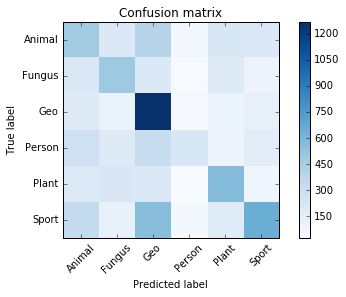

In [106]:
plt.figure()
plot_confusion_matrix(cm)

In [107]:
accuracy = (np.array(true_arr) == np.array(pred_arr)).sum() / float(len(true_arr))
print accuracy

0.408590185824
